# 04-2 전이 학습으로 영화 리뷰 텍스트의 감성 분류하기

*이 노트북은 코랩의 A100 GPU 런타임으로 테스트했습니다.*

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/04-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

04-1절에서 정의한 `transformer_encoder()` 함수를 재사용합니다.

In [1]:
# x는 토큰 임베딩과 위치 임베딩을 더한 값입니다.
def transformer_encoder(x, padding_mask, dropout, activation='relu'):
    residual = x
    key_dim = hidden_dim // num_heads
    # 멀티 헤드 어텐션을 통과합니다.
    x = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)(
        query=x, value=x, attention_mask=padding_mask)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    residual = x
    # 위치별 피드 포워드 네트워크
    x = layers.Dense(hidden_dim * 4, activation=activation)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    return x

## 트랜스포머 인코더 기반 언어 이해 모델 - BERT

In [2]:
import keras_nlp

# BERT 베이스
vocab_size = 30522
num_layers = 12
num_heads = 12
hidden_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

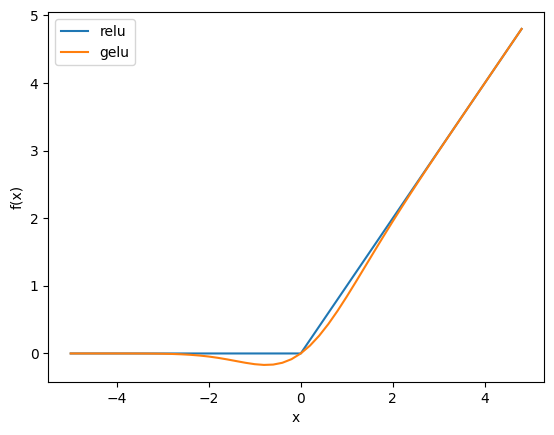

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf

def gelu(x):
    cdf = 0.5 * (1.0 + erf(x / np.sqrt(2.0)))
    return x * cdf

x = np.arange(-5, 5, 0.2)

plt.plot(x, x.clip(0), label='relu')
plt.plot(x, gelu(x), label='gelu')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [4]:
import keras
from keras import layers

In [5]:
token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, hidden_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)
seg_embedding = layers.Embedding(2, hidden_dim)(segment_ids)

x = layers.Add()((token_embedding, pos_embedding, seg_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

outputs = layers.Dense(hidden_dim, activation='tanh')(x[:,0,:])
model = keras.Model(inputs=(token_ids, segment_ids, padding_mask),
                    outputs=(outputs))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 768) │ 23,440,896 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 768) │    393,216 │ embedding[0][0]   │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 768) │      1,536 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 768) │          0 │ embedding[0][0],  │
│                     │                   │            │ position_embeddi… │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 768) │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 768) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 768) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 768) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 768) │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 768) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 768) │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 109,482,240 (417.64 MB)

 Trainable params: 109,482,240 (417.64 MB)

 Non-trainable params: 0 (0.00 B)

## KerasNLP로 영화 리뷰 텍스트의 감성 분류하기

### KerasNLP로 BERT 모델 로드하기

In [6]:
!gdown 15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
!tar -xzf aclImdb_v1.tar.gz
# 비지도 학습에 사용하는 데이터는 삭제합니다.
!rm -r aclImdb/train/unsup

Downloading...
From (original): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
From (redirected): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t&confirm=t&uuid=4db5d1ed-bea0-409a-b8d8-fdf75489970c
To: /content/aclImdb_v1.tar.gz
100% 84.1M/84.1M [00:00<00:00, 212MB/s]


In [7]:
train_ds, val_ds = keras.utils.text_dataset_from_directory('aclImdb/train',
                                                           subset='both',
                                                           validation_split=0.2,
                                                           seed=42)
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
feature, target = train_ds.unbatch().take(1).get_single_element()
print(feature.numpy()[:100])
print(target.numpy())

b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell '
0


In [9]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=2
)

100%|██████████| 507/507 [00:00<00:00, 1.01MB/s]


In [10]:
classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │             258 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

### BERT 모델 미세 튜닝하기

In [11]:
classifier.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - loss: 0.5728 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.3507 - val_sparse_categorical_accuracy: 0.8508
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.3218 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.8720
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.2557 - sparse_categorical_accuracy: 0.9007 - val_loss: 0.2904 - val_sparse_categorical_accuracy: 0.8860
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.1960 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.3387 - val_sparse_categorical_accuracy: 0.8680
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.1397 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.3396 - val_sparse_categorical_accuracy: 0.8754


In [12]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=1,
    activation='sigmoid'
)

In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)
classifier.compile(loss='binary_crossentropy',
                   optimizer=rmsprop,
                   metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
hist = classifier.fit(train_ds, validation_data=val_ds, epochs=20,
                      callbacks=[early_stopping_cb])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 106ms/step - accuracy: 0.6539 - loss: 0.5957 - val_accuracy: 0.7836 - val_loss: 0.4582
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.7959 - loss: 0.4513 - val_accuracy: 0.8244 - val_loss: 0.3962
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8334 - loss: 0.3927 - val_accuracy: 0.8302 - val_loss: 0.3805
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.8452 - loss: 0.3707 - val_accuracy: 0.8596 - val_loss: 0.3552
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.8635 - loss: 0.3426 - val_accuracy: 0.7886 - val_loss: 0.5603
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.8595 - loss: 0.3587 - val_accuracy: 0.8474 - val_loss: 0.3478
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8949 - loss: 0.2729 - val_accuracy: 0.8610 - val_loss: 0.3286
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9130 - loss: 0.2366 -

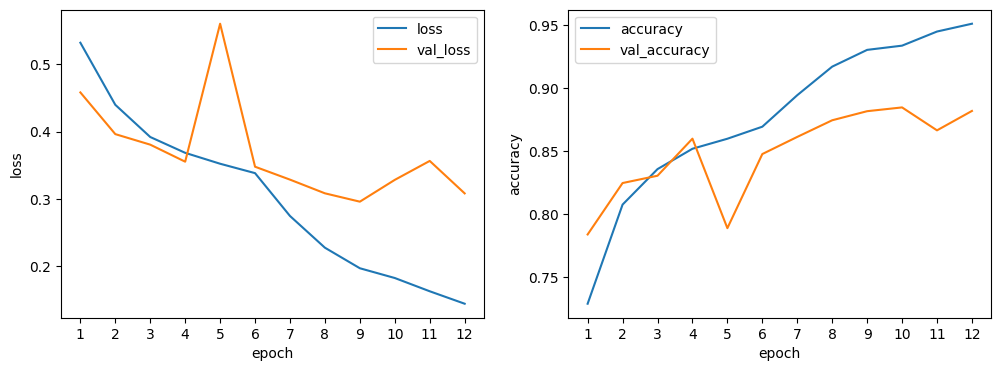

In [14]:
epochs = np.array(hist.epoch) + 1
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(epochs, hist.history['loss'], label='loss')
axs[0].plot(epochs, hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(epochs)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(epochs, hist.history['accuracy'], label='accuracy')
axs[1].plot(epochs, hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(epochs)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

In [15]:
classifier.predict([feature])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


array([[0.09800353]], dtype=float32)

In [16]:
classifier.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8568 - loss: 0.3568


[0.3586263656616211, 0.8569999933242798]

### 텍스트 전처리하기 - BERT 토크나이저

In [17]:
prep_data = classifier.preprocessor(feature)
print(len(prep_data['token_ids']), prep_data['token_ids'][:10])

512 tf.Tensor([  101  1000  6090  3207 26387  1000  2003  1037  5469  3185], shape=(10,), dtype=int32)


In [18]:
prep_data['token_ids'][-10:]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [19]:
sum(prep_data['padding_mask'].numpy())

np.int64(197)

In [20]:
bert_tokenizer = classifier.preprocessor.tokenizer
bert_tokenizer.detokenize(prep_data['token_ids'][:10])

'[CLS] " pandemonium " is a horror movie'

In [21]:
tokens = []
for id in prep_data['token_ids'][:10]:
    tokens.append(bert_tokenizer.id_to_token(id))
print(tokens)

['[CLS]', '"', 'pan', '##de', '##monium', '"', 'is', 'a', 'horror', 'movie']


In [22]:
for token in tokens:
    print(bert_tokenizer.token_to_id(token), end=' ')

101 1000 6090 3207 26387 1000 2003 1037 5469 3185 

In [23]:
bert_tokenizer.tokenize('"pandemonium" is a horror movie')

<tf.Tensor: shape=(9,), dtype=int32, numpy=
array([ 1000,  6090,  3207, 26387,  1000,  2003,  1037,  5469,  3185],
      dtype=int32)>

## 허깅페이스로 영화 리뷰 텍스트의 감성 분류하기

### 네이버 영화 리뷰 데이터셋 준비하기

In [24]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" an

In [25]:
from datasets import load_dataset

nsmc = load_dataset("nsmc", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

nsmc.py:   0%|          | 0.00/3.18k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [26]:
print(nsmc)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [27]:
nsmc['train'][0]

{'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}

### 백본 모델 선택하기

In [28]:
from transformers import AutoModelForSequenceClassification

bert_kor = AutoModelForSequenceClassification.from_pretrained(
    'bongsoo/bert-small-kor-v1',
    num_labels=2)

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bongsoo/bert-small-kor-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
print(bert_kor)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(10022, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-1

### 입력 데이터 토큰화하기

In [30]:
from transformers import AutoTokenizer

bert_kor_tokenizer = AutoTokenizer.from_pretrained('bongsoo/bert-small-kor-v1')

tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/70.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/226k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [31]:
prep_data = bert_kor_tokenizer(nsmc['train'][0]['document'])
prep_data.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [32]:
prep_data['input_ids']

[2, 606, 261, 1519, 17, 17, 4668, 766, 1400, 1132, 1464, 1130, 2889, 3]

In [33]:
tokens = bert_kor_tokenizer.convert_ids_to_tokens(prep_data['input_ids'])
print(tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜', '##증', '##나', '##네', '##요', '목소리', '[SEP]']


In [34]:
bert_kor_tokenizer.convert_tokens_to_string(tokens)

'[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]'

In [35]:
def tokenize(batch):
    return bert_kor_tokenizer(batch['document'], padding=True, truncation=True)

In [36]:
nsmc_tokenized = nsmc.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [37]:
print(nsmc_tokenized)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [38]:
nsmc_train = nsmc_tokenized["train"].shuffle(seed=42).select(range(1000))
nsmc_test = nsmc_tokenized["test"].shuffle(seed=42).select(range(100))

### BERT 모델 미세 튜닝하기

In [39]:
import evaluate

metric = evaluate.load("accuracy")

In [40]:
import numpy as np

def compute_metrics(eval_pred):
    # (100, 2), (100,)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [41]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir='bert_kor_nsmc',
                                  num_train_epochs=5,
                                  eval_strategy='epoch',
                                  save_strategy='epoch',
                                  logging_steps=len(nsmc_train)//8,
                                  load_best_model_at_end=True,
                                  report_to="none")

trainer = Trainer(model=bert_kor,
                  train_dataset=nsmc_train,
                  eval_dataset=nsmc_test,
                  args=training_args,
                  compute_metrics=compute_metrics)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.625300,0.659292,0.660000
2,0.427700,0.497767,0.790000
3,0.289500,0.643535,0.790000
4,0.189300,0.691933,0.800000
5,0.104700,0.734328,0.800000


TrainOutput(global_step=625, training_loss=0.32730327911376955, metrics={'train_runtime': 14.5258, 'train_samples_per_second': 344.214, 'train_steps_per_second': 43.027, 'total_flos': 54844270920000.0, 'train_loss': 0.32730327911376955, 'epoch': 5.0})

In [42]:
preds_output = trainer.predict(nsmc_test)

In [43]:
print(preds_output.predictions[:7])
print(preds_output.label_ids[:7])

[[ 0.5382241  -0.57349265]
 [-1.9221013   2.0672815 ]
 [-1.753811    2.0413158 ]
 [-0.8721574   1.1453695 ]
 [ 1.3240745  -1.4225185 ]
 [ 0.7390001  -0.82469815]
 [-0.80312365  0.7663402 ]]
[0 1 1 1 0 1 0]


## 좀 더 알아보기

In [44]:
from transformers import pipeline

pipe = pipeline(task='text-classification', device=0,
                model='WhitePeak/bert-base-cased-Korean-sentiment')

config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [45]:
pipe('아 더빙.. 진짜 짜증나네요 목소리')

[{'label': 'LABEL_0', 'score': 0.997101366519928}]